# Предсказание стоимости жилья

In [2]:
import pandas as pd 
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, StandardScaler, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [3]:
# запускаем локальную spark-сессию
spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

# Предобработка данных

In [4]:
df = spark.read.csv('/datasets/housing.csv', inferSchema=True, header=True)
display(df.show(5))
df.dtypes

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

None

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string')]

В датасете 10 колонок, в 9 из них числовые значения и только в одной строковые. Для колонок `housing_median_age`, `total_rooms`, `total_bedrooms`, `population` и `households` больше подойдет тип `int`, ведь в них хранятся целочисленные значения, такие как возраст и количество комнат или человек.

## Заполнение пропусков

In [5]:
for column in df.columns:
    print(column, df.filter(df[column].isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


В `total_bedrooms` есть 207 пропусков. Количество комнат и количество спален должны быть связаны - может получиться заполнить пропуски на основе общего количества комнат.

rooms_beds    4.984829
dtype: float64

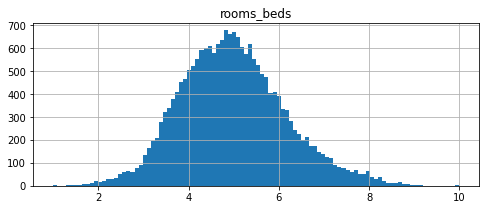

In [6]:
df.withColumn('rooms_beds', df['total_rooms'] / df['total_bedrooms'])\
    .select('rooms_beds').toPandas().hist(bins=100, figsize=(8, 3));
df.withColumn('rooms_beds', df['total_rooms'] / df['total_bedrooms'])\
    .select('rooms_beds').toPandas().mean()

Спален обычно в пять раз меньше, чем всех комнат. Пропуски можно заполнить количеством комнат, деленым на 5:

In [7]:
df = df.withColumn('total_bedrooms', F.when(df.total_bedrooms.isNull(), df.total_rooms / 5)\
          .otherwise(df.total_bedrooms))

print('total_bedrooms', df.filter(df['total_bedrooms'].isNull()).count())

total_bedrooms 0


## Поиск аномалий

In [8]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.6163178294578,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,420.7923178822386,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Почти во всех столбцах есть очень маленькие и большие значения.

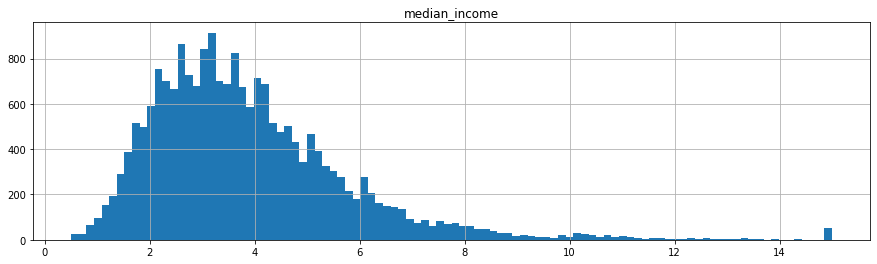

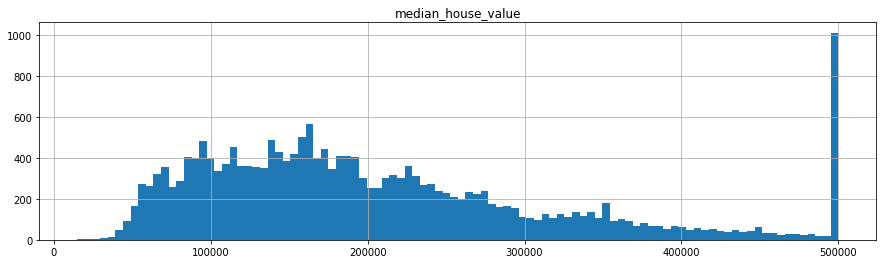

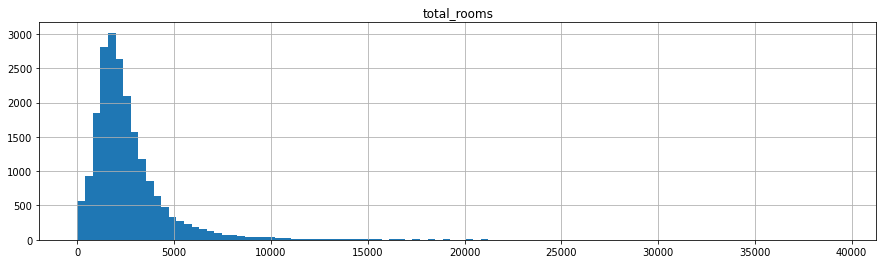

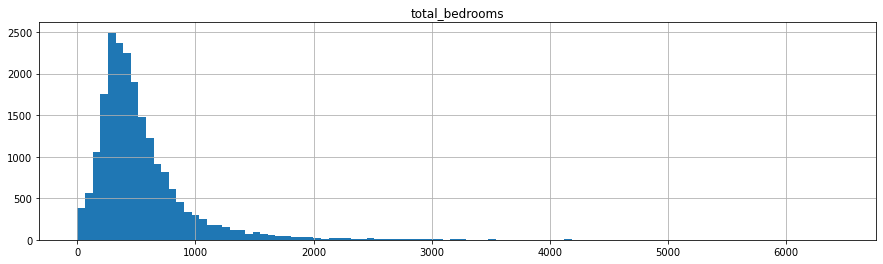

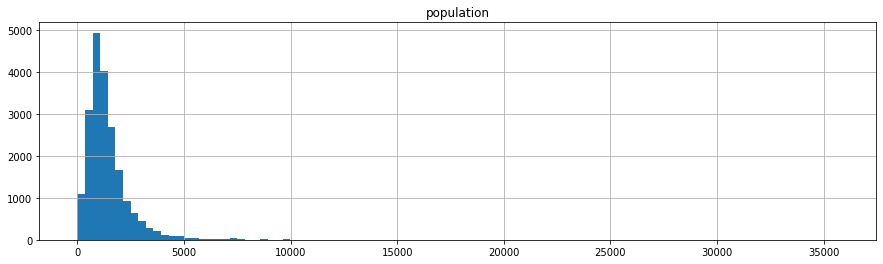

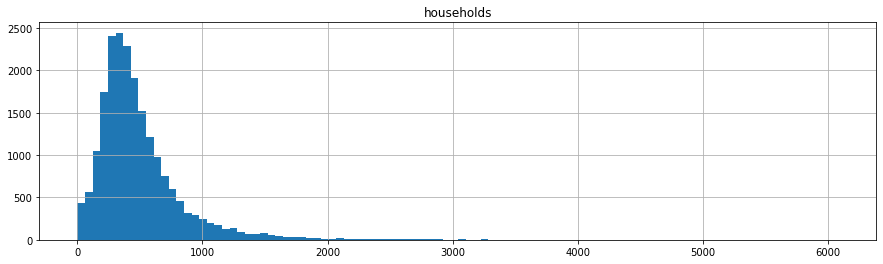

In [9]:
tocheck = ['median_income', 'median_house_value', 'total_rooms', 'total_bedrooms', 'population', 'households']

for c in tocheck:
    df.select(c).toPandas().hist(bins=100, figsize=(15, 4));

Во всех столбцах большие значения на графиках вытягиваются в длинные "хвосты", при этом не видно сильно выбивающихся значений, кроме как в `median_house_value` - здесь есть 1000 жилых массивов, медианная стоимость дома в которых равна 500 тыс., тогда как в основном стоимость домов находится в пределах 80 и 180 тыс.. Может произошла ошибка при создании датасета, а может это просто данные о 1000 элитных районов.

Для анализа и дальнейшего обучения модели "хвосты" с редкими значениями можно подрезать:

In [10]:
df = df.filter((df.median_income < 10) &\
              (df.total_rooms < 10000) &\
              (df.total_bedrooms < 2000) &\
              (df.population < 5000) &\
              (df.households < 2000))

In [11]:
df.select('ocean_proximity').groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,ISLAND,5
1,NEAR OCEAN,2555
2,NEAR BAY,2207
3,<1H OCEAN,8779
4,INLAND,6357


В столбце `ocean_proximity` всего 5 записей с категорией `ISLAND` - по 5 наблюдениям не опишешь целую категорию, удалим их:

In [12]:
df = df.filter((df.ocean_proximity != 'ISLAND'))
df.select('ocean_proximity').groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,NEAR OCEAN,2555
1,NEAR BAY,2207
2,<1H OCEAN,8779
3,INLAND,6357


Наконец, изменим тип столбцов на `int`:

In [13]:
toint = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value']

for c in toint:
    df = df.withColumn(c, F.col(c).cast('int'))
df.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'int'),
 ('total_rooms', 'int'),
 ('total_bedrooms', 'int'),
 ('population', 'int'),
 ('households', 'int'),
 ('median_income', 'double'),
 ('median_house_value', 'int'),
 ('ocean_proximity', 'string')]

# Исследование данных

Нужно выяснить, от чего зависит медианная стоимость дома и почему может быть так много жилых массивов с домами стоимостью 500 тыс..

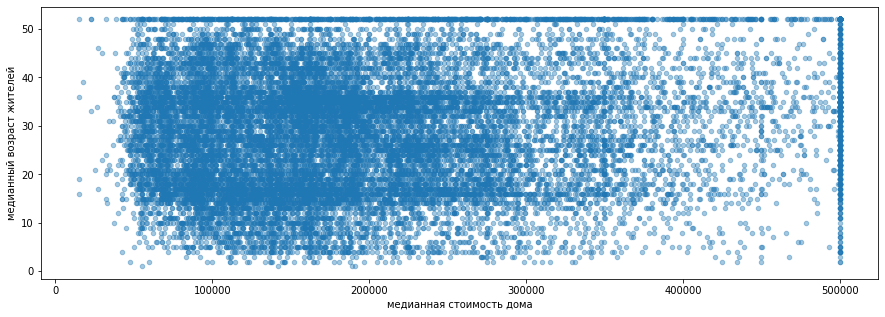

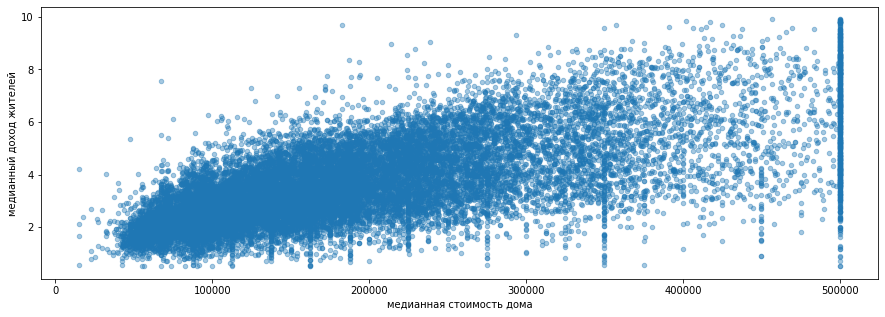

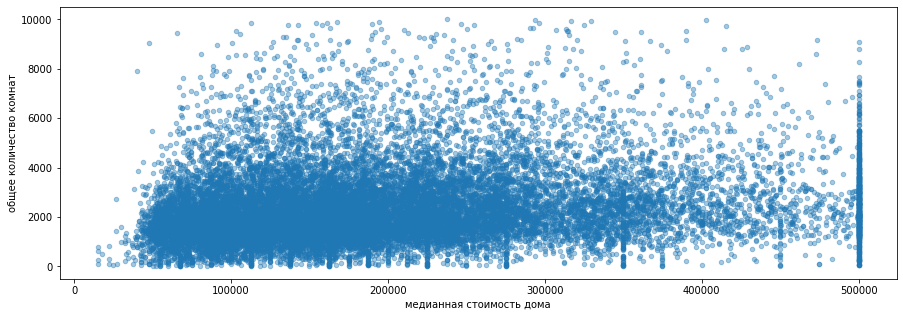

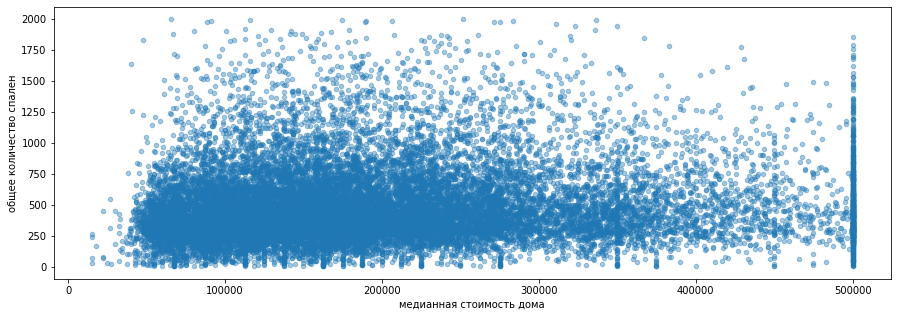

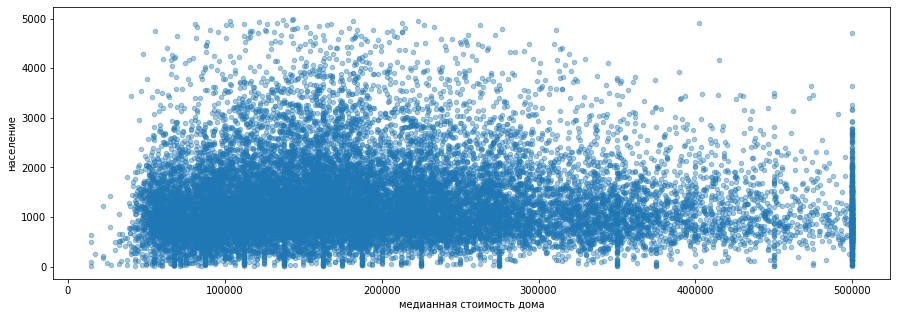

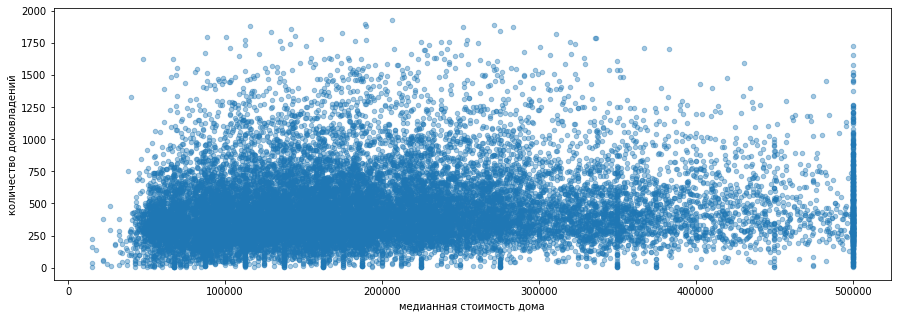

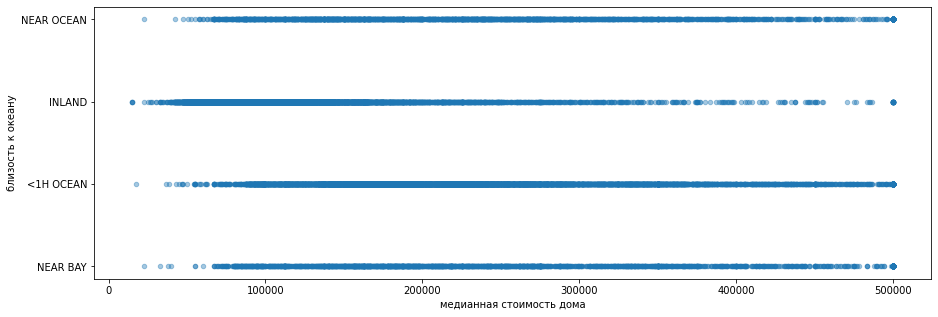

In [14]:
toplot = [('housing_median_age', 'медианный возраст жителей'),
          ('median_income', 'медианный доход жителей'),
          ('total_rooms', 'общее количество комнат'),
          ('total_bedrooms', 'общее количество спален'),
          ('population', 'население'),
          ('households', 'количество домовладений'),
          ('ocean_proximity', 'близость к океану')]

for c in toplot:
    df.select('median_house_value', c[0]).toPandas()\
        .plot(kind='scatter', x='median_house_value', y=c[0], figsize=(15, 5), alpha=0.4,\
             xlabel='медианная стоимость дома', ylabel=c[1]);

Столбик на 500 тыс. на графиках выглядит так плотно, будто в данных должны были быть значения больше, но их решили "урезать", заменив "все, что больше 500000" на 500001. Такие данные будут не очень полезны, ведь по ним не получится отследить зависимости. Попробуем без этих значений:

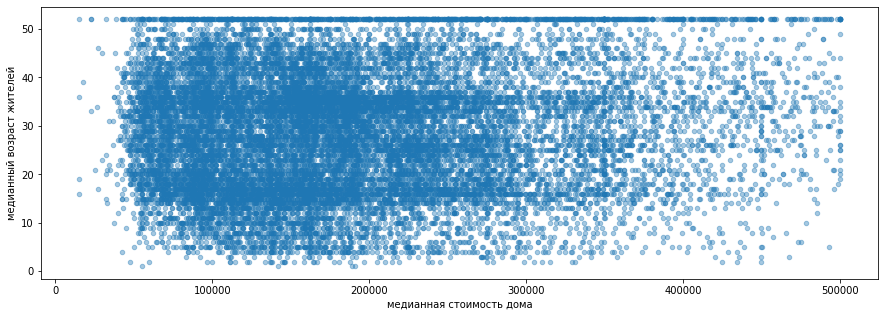

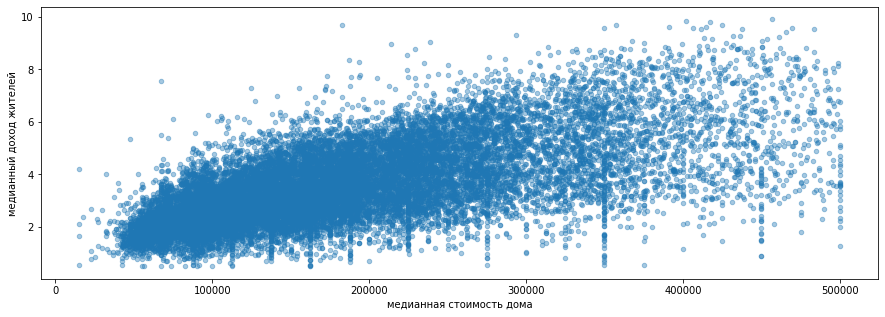

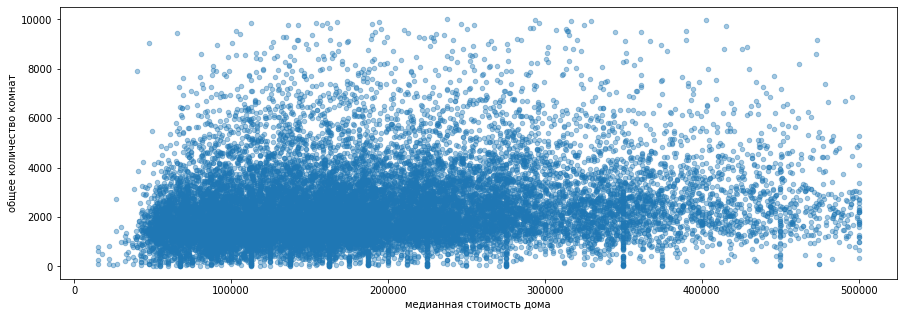

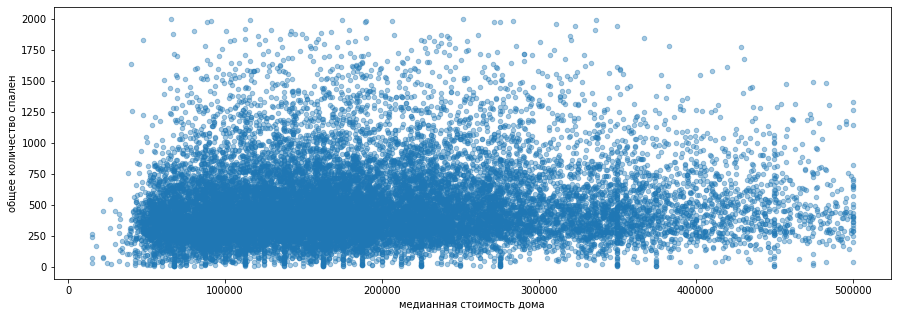

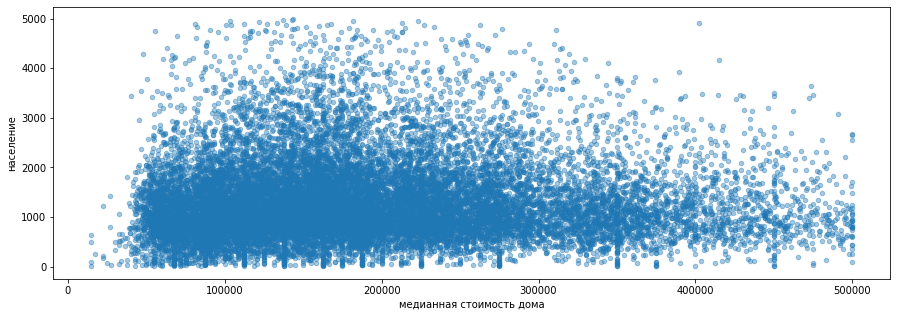

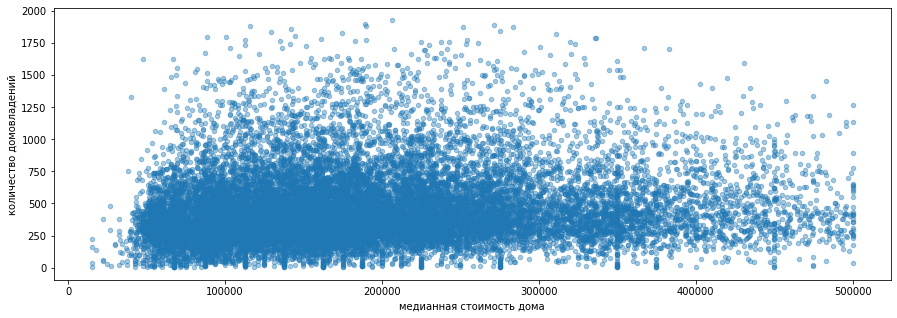

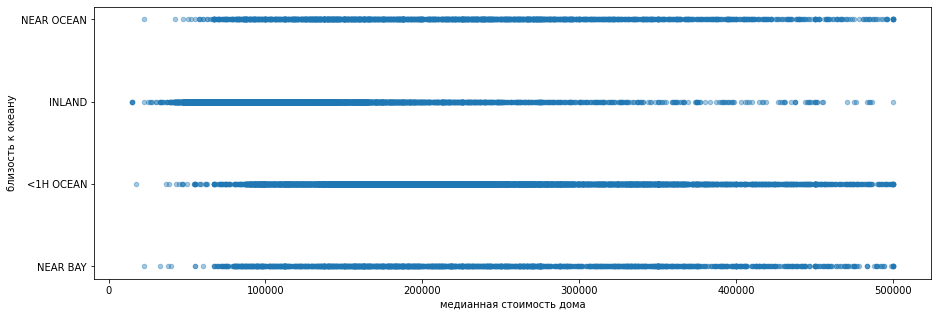

In [15]:
for c in toplot:
    df.select('median_house_value', c[0]).where(df['median_house_value'] < 500001).toPandas()\
        .plot(kind='scatter', x='median_house_value', y=c[0], figsize=(15, 5), alpha=0.4,\
             xlabel='медианная стоимость дома', ylabel=c[1]);

Самая четкая зависимость видна на графике с доходом жителей: чем больше доход, тем дороже люди могут позволить себе дом, что логично. В домах стоимостью до 100 тыс. доход обычно не больше 4, от 100 до 200 тыс. доход может составлять уже 6. Начиная от 300 тыс. доход жителей более разбросан и уже может достигать 9 и 10, заметно реже встречаются доходы меньше 4.

Графики с населением, количеством комнат, спален и домовладений очень похожи: в основном значения расположены в нижней половине графика; начиная от 300 тыс. значений становится все меньше, и сами они также уменьшаются, что тоже логично - чем дороже дома в жилом массиве, тем меньше будет самих домов, чем меньше домов, тем меньше комнат в них и меньше население.

На графике с возрастом, похоже, тоже "урезали" максимальный возраст до 52, но это не сильно помешает анализу. Много значений сосредоточено вокруг 18 и 35 лет, в массивах с домами стоимостью от 100 до 200 тыс. все возраста встречаются почти одинаково часто. Там, где дома стоят менее 100 или более 300 тыс. детей и пожилых людей гораздо меньше.

Близость к океану влияет на цену, но заметная разница есть только между районами, где до океана можно добраться менее чем за час, и районами, где до океана очень далеко. Редко встречаются районы близко к океану, где дом стоит менее 70 тыс., далекие от океана дома редко стоят больше 400 тыс..

# Подготовка данных

Выяснилось, что медианной стоимости дома и возрасту жителей урезали максимальные значения. Такие данные будут вредны для модели, от них придется избавиться:

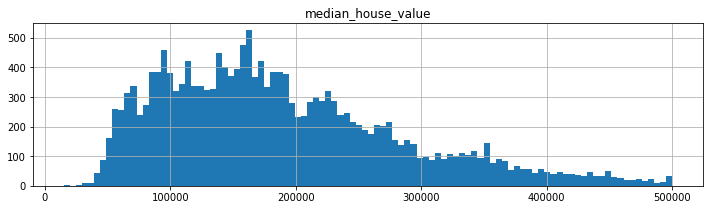

In [16]:
df = df.filter((df.median_house_value < 500001) & (df.housing_median_age < 52))
df.select('median_house_value').toPandas().hist(bins=100, figsize=(12, 3));

Разделим оставшиеся данные на обучающую и тестовую выборку:

In [17]:
train_data, test_data = df.randomSplit([.8,.2], seed=42)
print(train_data.count(), test_data.count())

14554 3565


Теперь данные нужно подготовить для обучения модели - закодировать категориальный признак, масштабировать числовые признаки и собрать все в один вектор с признаками. При этом категориальный признак в данных только один, можно попробовать обучить модель и на всех данных, и на данных без него.

In [18]:
categorical_cols = ['ocean_proximity']
numerical_cols = ['latitude', 'longitude', 'housing_median_age', 'median_income', 'total_rooms', 'total_bedrooms',\
                  'population', 'households']
target = 'median_house_value'

In [19]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols]) 
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")

numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="features_num")

final_assembler = VectorAssembler(inputCols=['categorical_features', 'features_num'], outputCol="features") 

Собираем пайплайны для обработки выборок: индексирование категорий и ОНЕ кодирование для категориальной колонки, масштабирование числовых колонок и сборка всех признаков в один вектор - основные шаги в пайплайнах:

In [20]:
pipe_all_features = Pipeline(stages=[indexer, encoder, categorical_assembler, 
                                     numerical_assembler, standardScaler, final_assembler])
pipe_num_features = Pipeline(stages=[numerical_assembler, standardScaler])

In [21]:
paf = pipe_all_features.fit(train_data)
pnf = pipe_num_features.fit(train_data)

Трансформируем выборку из всех данных:

In [71]:
features_train = paf.transform(train_data)
features_test = paf.transform(test_data)
display(pd.DataFrame(data=features_train.first().asDict().items()).T)
display(pd.DataFrame(data=features_test.first().asDict().items()).T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,categorical_features,numerical_features,features_num,features
1,-124.3,41.8,19,2672,552,1298,478,1.9797,85800,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0)","[0.0, 0.0, 1.0]","[41.8, -124.3, 19.0, 1.9797, 2672.0, 552.0, 12...","[19.36916020801478, -62.60468932561999, 1.6852...","[0.0, 0.0, 1.0, 19.36916020801478, -62.6046893..."


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,categorical_features,numerical_features,features_num,features
1,-124.27,40.69,36,2349,528,1194,465,2.5179,79000,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0)","[0.0, 0.0, 1.0]","[40.69, -124.27, 36.0, 2.5179, 2349.0, 528.0, ...","[18.85481169531391, -62.58957958563794, 3.1931...","[0.0, 0.0, 1.0, 18.85481169531391, -62.5895795..."


И выборку только с числовыми данными:

In [74]:
features_train_num = pnf.transform(train_data)
features_test_num = pnf.transform(test_data)
display(pd.DataFrame(data=features_train_num.first().asDict().items()).T)
display(pd.DataFrame(data=features_test_num.first().asDict().items()).T)

,0,1,2,3,4,5,6,7,8,9,10,11
0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,numerical_features,features_num
1,-124.3,41.8,19,2672,552,1298,478,1.9797,85800,NEAR OCEAN,"[41.8, -124.3, 19.0, 1.9797, 2672.0, 552.0, 12...","[19.36916020801478, -62.60468932561999, 1.6852..."


,0,1,2,3,4,5,6,7,8,9,10,11
0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,numerical_features,features_num
1,-124.27,40.69,36,2349,528,1194,465,2.5179,79000,NEAR OCEAN,"[40.69, -124.27, 36.0, 2.5179, 2349.0, 528.0, ...","[18.85481169531391, -62.58957958563794, 3.1931..."


# Обучение моделей

Для предсказания цены будем использовать оценщик `LinearRegression`, для оценки качества модели три метрики: RMSE, MAE и R2.

In [23]:
rmse = RegressionEvaluator(predictionCol="predictions", labelCol=target, metricName='rmse')
mae = RegressionEvaluator(predictionCol="predictions", labelCol=target, metricName='mae')
r2 = RegressionEvaluator(predictionCol="predictions", labelCol=target, metricName='r2')

Первая модель обучается на всех данных:

In [31]:
lr = LinearRegression(labelCol='median_house_value', featuresCol='features', predictionCol='predictions',\
                      regParam=0.01)
model = lr.fit(features_train)

predictions_1 = model.transform(features_test)
predictions_1.select('median_house_value', "predictions").show(5)

+------------------+------------------+
|median_house_value|       predictions|
+------------------+------------------+
|             79000| 178319.2640553359|
|             58100|138721.81441981066|
|             68400|132644.57817086577|
|            107000|183031.08763673622|
|             86400|179866.57145751035|
+------------------+------------------+
only showing top 5 rows



In [32]:
print("RMSE: {0:.2f}".format(rmse.evaluate(predictions_1)))
print("MAE: {0:.2f}".format(mae.evaluate(predictions_1)))
print("R2: {0:.2f}".format(r2.evaluate(predictions_1)))

RMSE: 57134.17
MAE: 42493.84
R2: 0.63


Вторая модель обучается только на числовых данных:

In [33]:
lr = LinearRegression(labelCol='median_house_value', featuresCol='features_num', predictionCol='predictions',\
                      regParam=0.01)
model = lr.fit(features_train_num)

predictions_2 = model.transform(features_test_num)
predictions_2.select('median_house_value', "predictions").show(5)

+------------------+------------------+
|median_house_value|       predictions|
+------------------+------------------+
|             79000| 147815.3892420344|
|             58100|105274.28824446723|
|             68400| 83154.21981448494|
|            107000| 151946.9419923951|
|             86400|148190.89538569655|
+------------------+------------------+
only showing top 5 rows



In [34]:
print("RMSE: {0:.2f}".format(rmse.evaluate(predictions_2)))
print("MAE: {0:.2f}".format(mae.evaluate(predictions_2)))
print("R2: {0:.2f}".format(r2.evaluate(predictions_2)))

RMSE: 58226.15
MAE: 43777.96
R2: 0.61


# Анализ результатов

Прежде чем обучать модели данные нужно было подготовить: заполнить пропуски, убрать выбросы, закодировать и масштабировать выборки. В подготовленных данных средняя медианная цена домов равна `mean_value`. Зная это, можно расчитать размер ошибки в предскзаниии в процентах от средней цены:

In [37]:
mean_value = round(df.select('median_house_value').toPandas().mean()[0])
print('средняя медианная цена домов:', mean_value)

print('RMSE, модель 1: {0:.1f}%'.format(rmse.evaluate(predictions_1) / mean_value * 100))
print('MAE, модель 1: {0:.1f}%'.format(mae.evaluate(predictions_1) / mean_value * 100))

print('RMSE, модель 2: {0:.1f}%'.format(rmse.evaluate(predictions_2) / mean_value * 100))
print('MAE, модель 2: {0:.1f}%'.format(mae.evaluate(predictions_2) / mean_value * 100))

средняя медианная цена домов: 188699
RMSE, модель 1: 30.3%
MAE, модель 1: 22.5%
RMSE, модель 2: 30.9%
MAE, модель 2: 23.2%


Первая модель, обученная на всех данных, показала RMSE равную 57134, что составило 30.3% от средней цены домов в жилом массиве. МАЕ этой модели равна 42493, или 22.5% от средней цены. Вторая модель, обученная только на числовых данных, показала RMSE больше - 58226, или 30.9%. МАЕ также получилась больше - 43777, или 23.2% от средней цены. R2 первой модели - 0.63, что всего на 0.02 лучше, чем у второй. В целом первая модель обучилась немного лучше, чем вторая - в категориальном признаке все же были полезные для модели данные.

Сами по себе результаты далеки от хороших. Ошибки RMSE и МАЕ показывают, что предсказания отличаются от действительных значений в среднем на 27%. R2, равный 0.6 также показывает, что модели не смогли найти сильной зависимости цены от признаков - в анализе также не наблюдалось сильных линейных зависимостей. Может они были более сложные, и линейная регрессия просто не подходящий оценщик для этого набора данных.

In [38]:
# завершаем spаrk-сессию
spark.stop()